In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer
import tensorflow as tf
import akshare as ak
from tensorflow.keras.optimizers import Adam


In [2]:
## 超参数集合调整
stock_code = "000001"

贵州茅台（600519.SH）：消费行业龙头，市值高，交易活跃。\
平安银行（000001.SZ）：金融行业代表，市值高，交易活跃。\
中国平安（601318.SH）：保险行业龙头，市值高，交易活跃。\
恒瑞医药（600276.SH）：医药行业龙头，市值高，具有行业代表性。\
招商银行（600036.SH）：银行业龙头，市值高，交易活跃。\
万科A（000002.SZ）：房地产行业代表，市值高，交易活跃。\
五粮液（000858.SZ）：白酒行业龙头，市值高，交易活跃。\
海康威视（002415.SZ）：科技行业代表，市值高，交易活跃。

#### 数据预处理是非常重要的，决定了最终效果

In [3]:
# 加载数据
# df = pd.read_csv('AAPL_stock_data.csv')

df = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date="20230701", end_date="20240701", adjust="qfq")

stock_info = ak.stock_zh_a_spot_em()[ak.stock_zh_a_spot_em()['代码'] == stock_code]
stock_name = stock_info['名称'].values[0] if not stock_info.empty else "Unknown"
# df = pd.read_csv(f'dataset/{stock_name}.csv')
print(stock_name)
# df.to_csv(f'dataset/{stock_name}.csv')
df.head()


平安银行


,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2023-07-03,000001,10.52,10.77,10.81,10.51,885091,1.009887e+09,2.85,2.47,0.26,0.46
1,2023-07-04,000001,10.74,10.68,10.77,10.60,616301,7.018853e+08,1.58,-0.84,-0.09,0.32
2,2023-07-05,000001,10.64,10.62,10.68,10.58,423482,4.797263e+08,0.94,-0.56,-0.06,0.22
3,2023-07-06,000001,10.58,10.52,10.62,10.49,597096,6.723968e+08,1.22,-0.94,-0.10,0.31
4,2023-07-07,000001,10.48,10.48,10.55,10.46,484441,5.432125e+08,0.86,-0.38,-0.04,0.25


In [4]:
##　以收盘价作为目标
# data = df[['收盘']].values
data = df[['日期', '收盘']]
data.set_index('日期', inplace=True) ## 作为索引值


# data = data.reshape(-1, 1) ## 重塑为二维数组，方便与进入MinMaxScaler，多变量则不需
data

,收盘
日期,
2023-07-03,10.77
2023-07-04,10.68
2023-07-05,10.62
2023-07-06,10.52
2023-07-07,10.48
...,...
2024-06-25,10.08
2024-06-26,10.08
2024-06-27,10.13


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1)) ### 定义一个数据处理器
scaled_data = scaler.fit_transform(data)
## 给他标准化一下，便于处理
scaled_data

array([[0.74545455],
       [0.71818182],
       [0.7       ],
       [0.66969697],
       [0.65757576],
       [0.65757576],
       [0.66060606],
       [0.66969697],
       [0.72727273],
       [0.73636364],
       [0.69090909],
       [0.67272727],
       [0.69090909],
       [0.69393939],
       [0.7       ],
       [0.67575758],
       [0.81515152],
       [0.8       ],
       [0.82424242],
       [0.97878788],
       [0.9969697 ],
       [0.94848485],
       [0.90909091],
       [1.        ],
       [0.99090909],
       [0.94848485],
       [0.93030303],
       [0.95151515],
       [0.94848485],
       [0.86666667],
       [0.8       ],
       [0.81818182],
       [0.81818182],
       [0.76969697],
       [0.76666667],
       [0.69393939],
       [0.70909091],
       [0.67272727],
       [0.63636364],
       [0.66666667],
       [0.75454545],
       [0.69090909],
       [0.63636364],
       [0.63636364],
       [0.69393939],
       [0.76666667],
       [0.71515152],
       [0.727

In [6]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
print(len(train_data))
## 划分训练数据和测试数据

def create_dataset(dataset, time_step=1): ## 定义一个函数，用来构建数据集，输入一个原始csv，和时间步长
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


193


In [7]:
time_step = 3

print(train_data[0 + time_step, :])

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_train.shape)

# print(len(X_test))
# print(X_train,X_test)
# 重塑输入数据为LSTM的要求格式 [samples, time steps, features] ps:感觉多变量没啥用
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

[0.66969697]
(189, 3)


### 构建模型部分 
----

In [8]:
model_name = 'LSTM'
units = 1000
dropout_rate = 0.2
patience = 50
vp = 0.4
epochs = 20

In [9]:
from timeseries_predictor import TimeSeriesPredictor as tsf

In [10]:
model = tsf(model_type=model_name, input_shape=(time_step, X_train.shape[2]), units=units, dropout_rate=dropout_rate, patience=patience)

model.train(X_train, y_train, validation_split=vp, epochs=epochs, batch_size=32)

Epoch 1/20
4/4 [==============================] - 5s 404ms/step - loss: 0.2218 - val_loss: 0.0304
Epoch 2/20
4/4 [==============================] - 0s 43ms/step - loss: 0.0282 - val_loss: 0.0077
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 4/20
4/4 [==============================] - 0s 41ms/step - loss: 0.0110 - val_loss: 0.0060
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 6/20
4/4 [==============================] - 0s 39ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 7/20
4/4 [==============================] - 0s 37ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 8/20
4/4 [==============================] - 0s 28ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 9/20
4/4 [==============================] - 0s 27ms/step - loss: 0.0045 - val_loss: 0.0070
Epoch 10/20
4/4 [==============================] - 0s 26ms/step - loss: 0.0031 - val_loss: 0.0065
Epoch 11/20
4/4 [===========

----

In [11]:
# 保存模型配置到txt文件
config = {
    'model_name': model_name,
    'time_step': time_step,
    'units': units,
    'dropout_rate': dropout_rate,
    'patience': patience,
}

config_file = f'{model_name}/best_{model_name}_config.txt'
with open(config_file, 'w') as f:
    for key, value in config.items():
        f.write(f"{key}: {value}\n")

print(f"Model configuration saved to {config_file}")

Model configuration saved to LSTM/best_LSTM_config.txt


#### 开始预测

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 进行预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 逆归一化数据
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"y_test_actual shape: {y_test_actual.shape}")
print(f"test_predict shape: {test_predict.shape}")
### 滑动窗口问题，需要截一下
test_predict = test_predict[2:]
y_test_actual = y_test_actual[:len(y_test_actual) - 2]

# 计算评价指标
wmape = np.sum(np.abs(y_test_actual - test_predict)) / np.sum(np.abs(y_test_actual)) * 100
mse = mean_squared_error(y_test_actual, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, test_predict)
r2 = r2_score(y_test_actual, test_predict)
gflops = model.calculate_flops()
params = model.calculate_params()
# 打印评价指标
print(f"WMAPE: {wmape:.2f}%")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"GFLOPs:{gflops / 10**9},Params:{params / 10**9} M\n")
# 将评价指标保存到文本文件
with open(f'{model_name}/{model_name}_{stock_name}_evaluation.txt', 'w') as f:
    f.write(f"WMAPE: {wmape:.2f}%\n")
    f.write(f"MSE: {mse}\n")
    f.write(f"RMSE: {rmse}\n")
    f.write(f"MAE: {mae}\n")
    f.write(f"R2: {r2}\n")
    f.write(f"GFLOPs:{gflops / 10**9},Params:{params / 10**9} M\n")


2/2 [==============================] - 0s 3ms/step
y_test_actual shape: (45, 1)
test_predict shape: (45, 1)
WMAPE: 0.45%
MSE: 0.0030052887691859316
RMSE: 0.05482051412734043
MAE: 0.04644288794938907
R²: 0.9596751610719214
GFLOPs:0.002003001,Params:0.013014001 M



#### 可视化结果

In [22]:
import matplotlib.dates as mdates

43
43


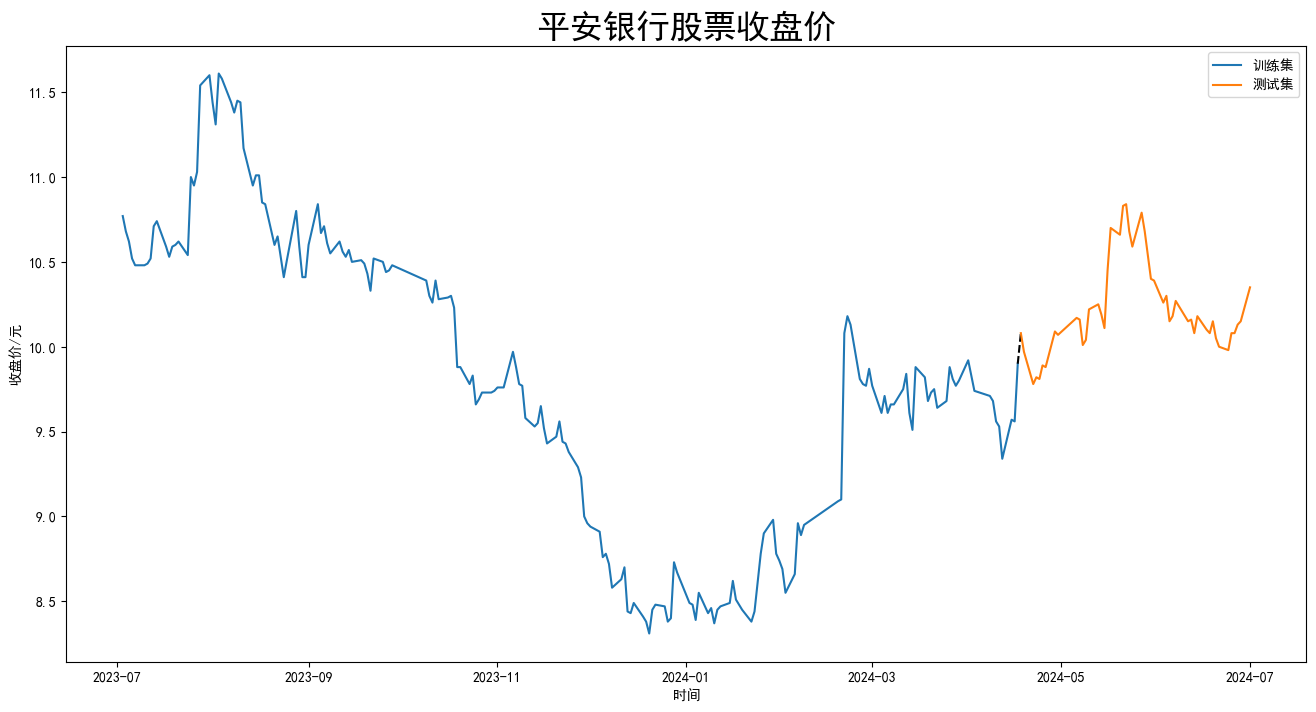

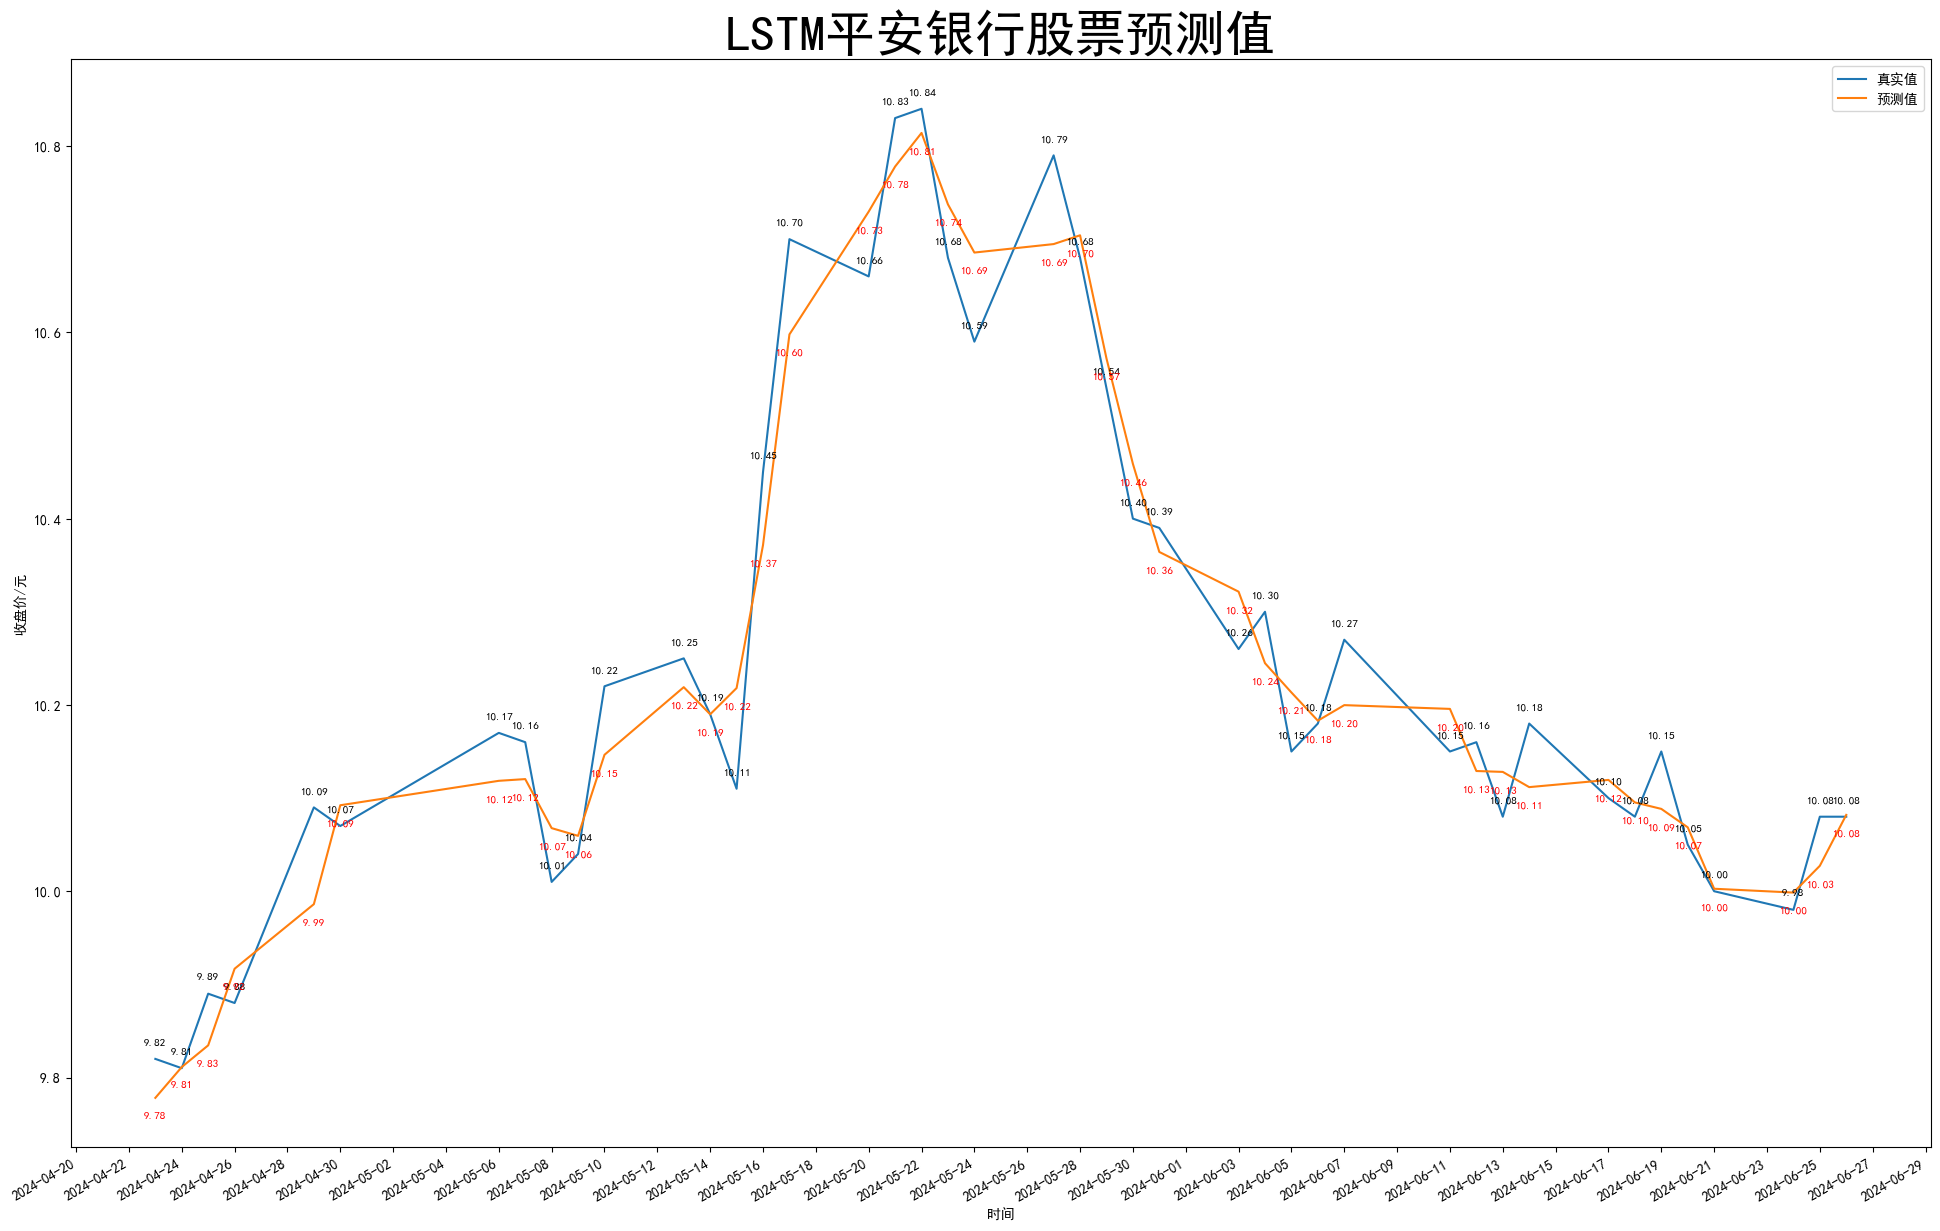

In [23]:
# 获取测试集对应的日期
# test_dates = data.index[len(train_data) + time_step + 1:len(data) - 1]
#### 滑动窗口，有问题，需要截一下
test_dates = data.index[len(train_data) + time_step :len(train_data) + time_step + len(test_predict)]


print(len(test_dates))
print(len(test_predict))

# 绘制测试集预测值
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(16, 8))
plt.plot(data.index[:train_size], scaler.inverse_transform(train_data), label='训练集')
plt.plot([data.index[train_size - 1], data.index[train_size]], 
         [scaler.inverse_transform(train_data[-1].reshape(1, -1))[0][0], scaler.inverse_transform(test_data[0].reshape(1, -1))[0][0]], 
         color='black', linestyle='--')
# 绘制测试集
plt.plot(data.index[train_size:], scaler.inverse_transform(test_data), label='测试集')
plt.title(f'{stock_name}股票收盘价',fontsize=24)
plt.xlabel('时间')
plt.ylabel('收盘价/元')
plt.legend()

plt.savefig(f'{model_name}/数据集划分——{stock_name}.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(24, 16))
plt.plot(test_dates, y_test_actual, label='真实值')
plt.plot(test_dates, test_predict, label='预测值')

# 添加每个点的注释
for i, txt in enumerate(y_test_actual):
    plt.annotate(f'{txt[0]:.2f}', (test_dates[i], y_test_actual[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

for i, txt in enumerate(test_predict):
    plt.annotate(f'{txt[0]:.2f}', (test_dates[i], test_predict[i]), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8, color='red')


plt.title(f'{model_name}{stock_name}股票预测值',fontsize=36)
plt.xlabel('时间')
plt.ylabel('收盘价/元')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # 设置日期间隔
plt.gcf().autofmt_xdate()  # 自动旋转日期标签
plt.savefig(f'{model_name}/{model_name}{stock_name}.png', dpi=300, bbox_inches='tight')
plt.show()
